# Labeled Faces In The Wild Deep Learning Classification


## Desription

The LFW (Labeled Faces In The Wild) dataset is composed of 5479 clases (different persons) for more than 13000 images.

## Initialization

In [155]:
IMSIZE = [250, 250, 3]

## Load dataset

In [156]:
from sklearn.datasets import fetch_lfw_people

# Load dataset in color mode with centered on the faces
lfw_people = fetch_lfw_people(min_faces_per_person=3, color=True, resize=1.0,
                              slice_=(slice(70, 195), slice(78, 172)), funneled=True)

X = lfw_people.data
y = lfw_people.target

target_names = lfw_people.target_names
n_classes = target_names.shape[0]
n_samples, h, w, l = lfw_people.images.shape

# Reshape images 1D array to images matrix
X = X.reshape(-1, h, w, l).astype('uint8')

## Show images infos

In [157]:
print(f"Image dimensions: {w}x{h}x{l}")
print(f"Number of classes: {n_classes}")
print(f"Number of samples: {n_samples}")
print(target_names)

Image dimensions: 94x125x3
Number of classes: 901
Number of samples: 7606
['Aaron Peirsol' 'Abdoulaye Wade' 'Abdullah' 'Abdullah Gul'
 'Abdullah al-Attiyah' 'Abel Pacheco' 'Abid Hamid Mahmud Al-Tikriti'
 'Adam Sandler' 'Adel Al-Jubeir' 'Adolfo Aguilar Zinser' 'Adrien Brody'
 'Ahmed Chalabi' 'Ai Sugiyama' 'Aicha El Ouafi' 'Akbar Hashemi Rafsanjani'
 'Akhmed Zakayev' 'Al Gore' 'Al Pacino' 'Al Sharpton' 'Alan Greenspan'
 'Alastair Campbell' 'Albert Costa' 'Alec Baldwin' 'Alejandro Avila'
 'Alejandro Toledo' 'Aleksander Kwasniewski' 'Alex Sink'
 'Alexander Downer' 'Alexander Losyukov' 'Alexandra Stevenson'
 'Ali Khamenei' 'Ali Naimi' 'Allyson Felix' 'Alvaro Noboa'
 'Alvaro Silva Calderon' 'Alvaro Uribe' 'Amanda Bynes' 'Amelia Vega'
 'Amelie Mauresmo' 'Amer al-Saadi' 'Ana Guevara' 'Ana Palacio'
 'Anastasia Myskina' 'Anders Ebbeson' 'Anders Fogh Rasmussen'
 'Andre Agassi' 'Andrew Weissmann' 'Andy Roddick' 'Angela Bassett'
 'Angela Merkel' 'Angelina Jolie' 'Angelo Reyes' 'Anibal Ibarra'
 'Ann

## Show images

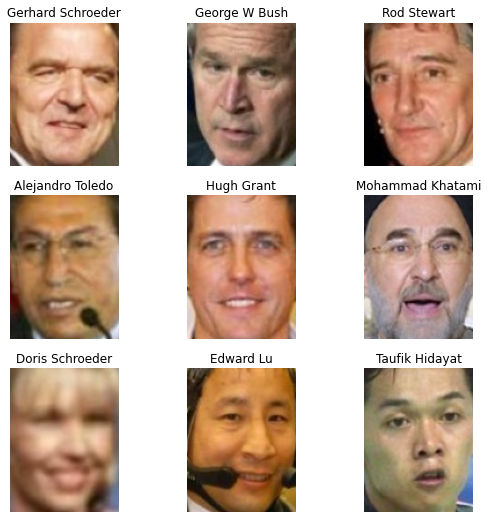

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i])
    # plt.imshow(X[i, 0:].reshape(h, w, l).astype('uint8'))# reshape above
    plt.title(target_names[y[i]])
    plt.axis("off")
plt.show()

## Split dataset

In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building model


In [160]:
from tensorflow import keras
from keras.optimizers import SGD
from keras import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.applications import ResNet50

batch_size = 8
epochs = 50
number_of_last_layers_trainable = 10
learning_rate = 0.001
nesterov = True
momentum = 0.9

preprocess_input = keras.applications.resnet.preprocess_input

model = ResNet50(
    input_shape=[h, w, 3],
    weights="imagenet",
    include_top=False,
    classes=n_classes,
)

for layer in model.layers[: number_of_last_layers_trainable]:
    layer.trainable = False

out = model.output

x = Flatten()(out)
x = Dense(n_classes, activation="softmax")(x)

model = Model(inputs=model.input, outputs=x)

opti = SGD(
    learning_rate=learning_rate,
    momentum=momentum,
    nesterov=nesterov,
)

# model.compile(loss="sparse_categorical_crossentropy", optimizer=opti, metrics=["accuracy"])

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opti, metrics=["accuracy"])
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 125, 94, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 131, 100, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 63, 47, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 63, 47, 64)   256         ['conv1_conv[0][0]']      

## Data augmentation

In [161]:
from keras_preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.05,
    shear_range=10,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.20,
    preprocessing_function=preprocess_input,
)

train_generator = image_gen.flow(
    x=X_train,
    y=y_train,
    shuffle=True,
    batch_size=batch_size,
)

test_generator = image_gen.flow(
    x=X_test,
    y=y_test,
    shuffle=True,
    batch_size=batch_size,
)

## Training

In [162]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", patience=2)
history = model.fit(train_generator,
          validation_data=test_generator,
          epochs=epochs,
          steps_per_epoch=len(X_train) // batch_size,
          validation_steps=len(X_test) // batch_size,
          callbacks=[early_stop])

Epoch 1/50
760/760 [==============================] - 53s 63ms/step - loss: 5.9488 - accuracy: 0.1460 - val_loss: 4.8079 - val_accuracy: 0.2388
Epoch 2/50
760/760 [==============================] - 46s 60ms/step - loss: 3.7943 - accuracy: 0.3355 - val_loss: 3.9323 - val_accuracy: 0.3447
Epoch 3/50
760/760 [==============================] - 48s 63ms/step - loss: 2.2961 - accuracy: 0.5302 - val_loss: 3.4983 - val_accuracy: 0.3934
Epoch 4/50
760/760 [==============================] - 49s 64ms/step - loss: 1.2072 - accuracy: 0.7138 - val_loss: 3.2773 - val_accuracy: 0.4388
Epoch 5/50
760/760 [==============================] - 52s 68ms/step - loss: 0.6776 - accuracy: 0.8322 - val_loss: 3.0340 - val_accuracy: 0.4987
Epoch 6/50
760/760 [==============================] - 53s 70ms/step - loss: 0.4053 - accuracy: 0.8943 - val_loss: 3.1718 - val_accuracy: 0.4868
Epoch 7/50
760/760 [==============================] - 52s 68ms/step - loss: 0.2637 - accuracy: 0.9315 - val_loss: 2.7704 - val_accuracy:

## Save model

In [163]:
# model.save_weights("../weights/resnet50_lfw.h5")

## Prediction

In [164]:
y_pred_test = model.predict(X_test, y_test)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Scores

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

# Confusion matrix
def print_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()


# ROC curve
def print_roc_curve(model, X_test, y_test, name, title):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=9)
    plt.plot(fpr, tpr, label=name)
    plt.xlabel("False positive")
    plt.ylabel("True positive")
    plt.title(title)
    plt.show()

print_confusion_matrix(y_test, y_pred_test)
print_roc_curve(model, X_test, y_test, "SVC", "svc roc curve")